# EGU: Shap Feature Importance

In [1]:
from pathlib import Path
import os
import warnings
from collections import namedtuple

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [41]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'one_month_forecast'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'
# TARGET_VAR =      'VCI3M'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


In [5]:
# # EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
# EXPERIMENT =      '000_one_month_forecast_BASE_static_vars'
# # TRUE_EXPERIMENT = 'one_month_forecast'
# TRUE_EXPERIMENT = '000_one_month_forecast_BASE_static_vars'
# TARGET_VAR =      'boku_VCI'

# assert (data_dir / f'models/{EXPERIMENT}').exists()
# assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

# print((data_dir / f'models/{EXPERIMENT}').as_posix())

# Read in the data

In [6]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [7]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
Data variables:
    boku_VCI    (time, lat, lon) float64 82.14 83.13 71.48 ... 29.12 77.78 49.71
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 4.625 4.678 4.806 4.71 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 74.48 83.21 84.39 ... 29.12 77.78 49.71

In [8]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

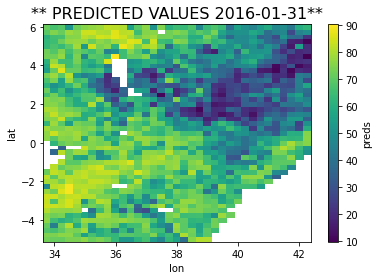

In [9]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [10]:
EXPERIMENT
# [d.name for d in (data_dir / 'models' / EXPERIMENT).iterdir()]

'one_month_forecast'

In [11]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

12

In [12]:
dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

### Check the static data

In [13]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 23


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lon                                         (lon) float32 33.75 ... 42.25
  * lat                                         (lat) float32 -5.0 -4.75 ... 6.0
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

In [14]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

# Run the Shap Analysis

- Run the `scripts/experiments/22_shap_analysis.py` file
- `ipython --pdb 22_shap_analysis.py`

# Open SHAP analysis

In [15]:
from pandas.tseries.offsets import MonthEnd


def get_timestep_from_date_str(date_str) -> pd.Timestamp:
    return pd.to_datetime(date_str, format="%Y_%m") + MonthEnd()


def open_shap_analysis(model) -> Dict[str, namedtuple]:  # type: ignore
    """Read the data from the SHAP analysis run in the other functions"""
    ShapValues = namedtuple(
        "ShapValues", ["date_str", "target_time", "historical", "pred_month", "static"]
    )

    analysis_dir = model.model_dir / "analysis"
    dirs = [d for d in analysis_dir.iterdir() if len(list(d.glob("*.nc"))) > 0]

    out_dict = {}
    for shap_analysis_dir in dirs:
        shap = ShapValues(
            date_str=shap_analysis_dir.name,
            target_time=get_timestep_from_date_str(shap_analysis_dir.name),
            historical=xr.open_dataset(shap_analysis_dir / "shap_historical_ds.nc"),
            pred_month=xr.open_dataset(shap_analysis_dir / "shap_pred_month.nc"),
            static=xr.open_dataset(shap_analysis_dir / "shap_static.nc"),
        )
        out_dict[shap_analysis_dir.name] = shap

    return out_dict

In [16]:
shap = open_shap_analysis(ealstm)
shap.keys()

dict_keys(['2016_4', '2016_5', '2017_11', '2018_1', '2017_12', '2018_7', '2018_9', '2016_1', '2017_6', '2016_7', '2018_10', '2018_8', '2017_3', '2017_1', '2017_4', '2018_11', '2016_6', '2016_8', '2018_4', '2018_5', '2016_2', '2017_7', '2016_9', '2017_5', '2017_8', '2016_10', '2016_12', '2018_12', '2017_9', '2016_3', '2018_6', '2018_3', '2017_10', '2016_11', '2017_2', '2018_2'])

# Create One Dataset object

In [17]:
# 1. add target time dimension
shap_t = shap['2018_2']
all_shap = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_shap.append(
        shap_t.historical.expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_shap = xr.concat(all_shap, dim='target_time')

In [18]:
# 1. add target time dimension
shap_t = shap['2018_2']
all_shap_t3 = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_shap_t3.append(
        shap_t.historical.isel(time=-1).expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_shap_t3 = xr.concat(all_shap_t3, dim='target_time')

In [19]:
# all_shap.isel(target_time=0).dropna(dim='time', how='all')

In [20]:
all_static = []
for shap_key in ([k for k in shap.keys()]):
    shap_t = shap[shap_key]
    all_static.append(
        shap_t.static.expand_dims({'target_time': [shap_t.target_time]})
    )

# 2. merge on the new target_time dimension
all_static = xr.concat(all_static, dim='target_time')

# Get the X_test data

In [21]:
from src.utils import create_shape_aligned_climatology

In [22]:
# create pixel-mean and pixel_std
means = X_train.mean(dim='time').drop([v for v in ealstm.ignore_vars if v in list(X_train.data_vars)])
stds = X_train.std(dim='time').drop([v for v in ealstm.ignore_vars if v in list(X_train.data_vars)])
ones = xr.ones_like(X_test.drop([v for v in ealstm.ignore_vars if v in list(X_train.data_vars)]))
variable='precip'

means = ones*means
stds = ones*stds
# create_shape_aligned_climatology(X_train, means, variable, time_period='month')

x_test = X_test.copy()
x_test = x_test.drop([v for v in ealstm.ignore_vars if v in list(x_test.data_vars)])
norm_x_test = (x_test - means) / stds
norm_x_test

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 38)
Coordinates:
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2015-10-31 2015-11-30 ... 2018-11-30
Data variables:
    boku_VCI  (time, lat, lon) float64 -1.744 -0.7433 -1.102 ... 0.9382 -0.3836
    VCI3M     (time, lat, lon) float64 -2.147 -1.245 -1.186 ... 0.8915 0.2015
    precip    (time, lat, lon) float64 0.3364 0.3544 -0.0631 ... -0.09866 0.2186
    E         (time, lat, lon) float64 -1.061 -1.103 -1.103 ... 0.4346 0.7895
    SMsurf    (time, lat, lon) float64 -1.005 -1.034 -1.034 ... 0.4001 0.3271
    t2m       (time, lat, lon) float64 2.08 2.026 2.091 ... -0.9274 -1.036

In [23]:
norm_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

# normalize the X data to compare with the shap values
# NEED TO NORMALIZE RELATIVE TO THE PIXEL MEANS ...
list_ds = []
for var in list(x_test.data_vars):
    list_ds.append((
        norm_ds[var] - ealstm.normalizing_dict[var]['mean']
    ) / ealstm.normalizing_dict[var]['std'])
    
    
norm_ds = xr.merge(list_ds)

# Get the normalised preds

In [24]:
# set the equivalent times
preds_mean = means[TARGET_VAR].isel(time=slice(0, len(ealstm_pred.time)))
preds_mean['time'] = ealstm_pred.time
preds_std = stds[TARGET_VAR].isel(time=slice(0, len(ealstm_pred.time)))
preds_std['time'] = ealstm_pred.time

In [25]:
norm_pred = (ealstm_pred - preds_mean) / preds_std
norm_pred = norm_pred.compute()

# Plot SHAP files

In [26]:
def plot_shap_obs_pairs(shap_ds: xr.Dataset, obs_ds: xr.Dataset, variables: List[str], shap_plot_kwargs: Dict, obs_plot_kwargs: Dict, norm: bool = False, scale=1) -> None:
    n_variables = len(variables)
    assert np.unique(shap_ds.time.values).shape == (1,), "Only works for a single time"
    fig, axs = plt.subplots(n_variables, 2, figsize=((6*2)*scale, (4*n_variables)*scale))
    
    for ix, variable in enumerate(variables):
        if n_variables > 1:
            ax_row = axs[ix, :]
        else:
            ax_row = axs
        time = pd.to_datetime(
            shap_ds.time.values
        )

        # plot shap values
        shap_ds[variable].plot(ax=ax_row[0], **shap_plot_kwargs)
        ax_row[0].set_title(f"{time._date_repr}: SHAP {variable}")

        # plot the observed data
        obs_ds.sel(time=time)[variable].where(~mask).plot(ax=ax_row[1], **obs_plot_kwargs)
        title = "NORM" if norm else "RAW"
        ax_row[1].set_title(f"{time._date_repr}: {title} {variable}")
        
        for ax in ax_row:
            ax.axis('off')

In [27]:
ealstm_pred

,Array,Chunk
Bytes,226.80 kB,6.30 kB
Shape,"(36, 45, 35)","(1, 45, 35)"
Count,217 Tasks,36 Chunks
Type,float32,numpy.ndarray


### 

In [28]:
norm_pred = ((ealstm_pred.compute() - ealstm.normalizing_dict['boku_VCI']['mean']) / ealstm.normalizing_dict['boku_VCI']['std'])

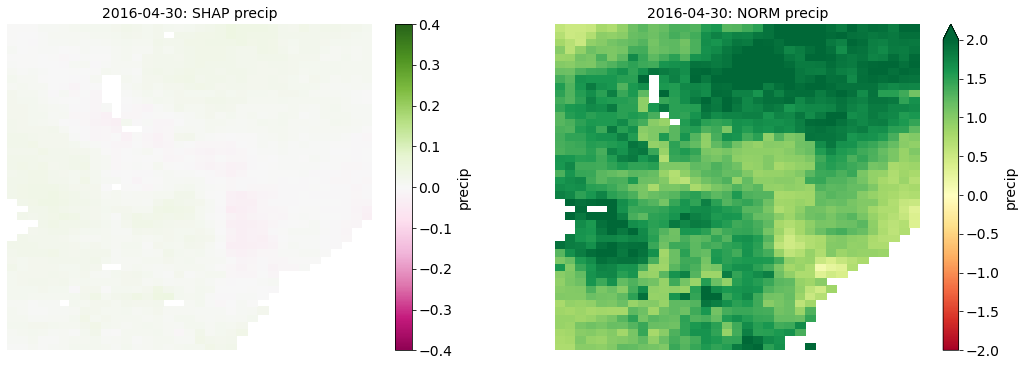

In [29]:
variables = list(ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)]).data_vars)

TIME = '2016_5'

plot_shap_obs_pairs(
    shap[TIME].historical.isel(time=-1), 
    norm_x_test, 
    ["precip"], 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True,
    scale=1.5
)
fig = plt.gcf()

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

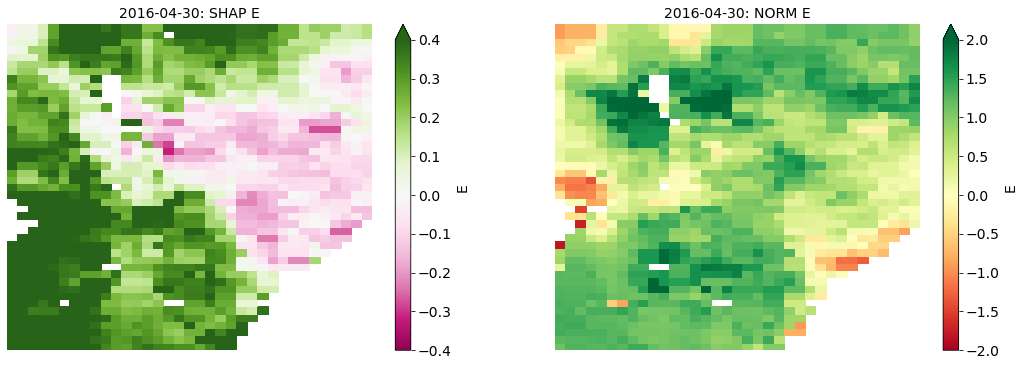

In [30]:
plot_shap_obs_pairs(
    shap[TIME].historical.isel(time=-1), 
    norm_x_test, 
    ["E"], 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True,
    scale=1.5
)
fig = plt.gcf()

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

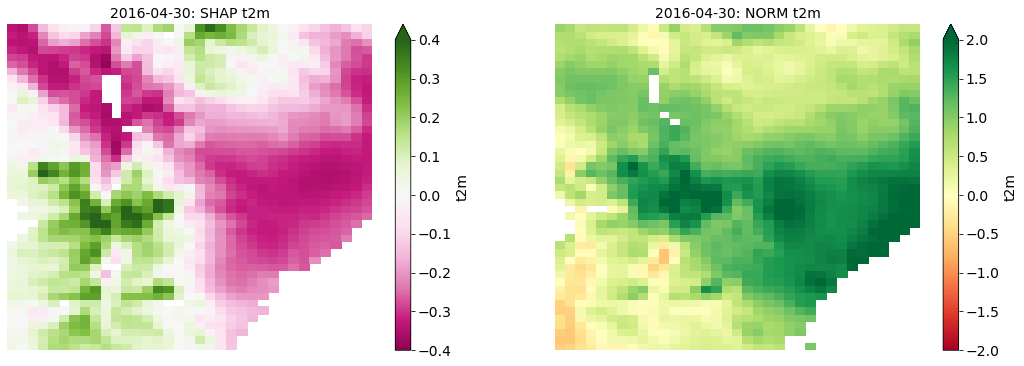

In [31]:
plot_shap_obs_pairs(
    shap[TIME].historical.isel(time=-1), 
    norm_x_test, 
    ["t2m"], 
    {'vmin': -0.4, 'vmax': 0.4, 'cmap': 'PiYG'}, 
    {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}, 
    norm=True,
    scale=1.5
)
fig = plt.gcf()

for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

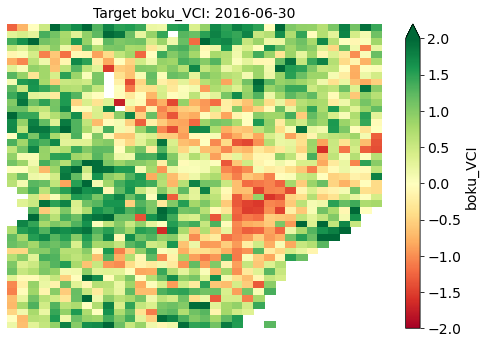

In [42]:
from pandas.tseries.offsets import MonthEnd, DateOffset
target_time = pd.to_datetime(TIME, format="%Y_%m") + MonthEnd() + DateOffset(months=1)
target = norm_ds[TARGET_VAR].sel(time=target_time)
predicted = norm_pred

kwargs = {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}
scale = 1.4
fig, ax = plt.subplots(1, 1, figsize=((6)*scale, (4)*scale))
target.plot(ax=ax, **kwargs)
ax.axis(False)
ax.set_title(f"Target {TARGET_VAR}: {pd.to_datetime(target.time.values)._date_repr}")
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

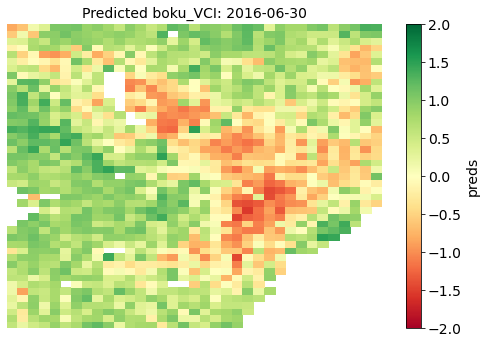

In [43]:
predicted = norm_pred.sel(time=target_time)

kwargs = {'cmap': 'RdYlGn', 'vmin':-2, 'vmax':2}
scale = 1.4
fig, ax = plt.subplots(1, 1, figsize=((6)*scale, (4)*scale))
predicted.plot(ax=ax, **kwargs)
ax.axis(False)
ax.set_title(f"Predicted {TARGET_VAR}: {pd.to_datetime(target.time.values)._date_repr}")
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

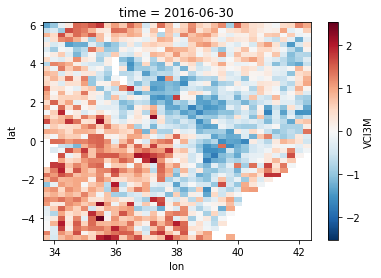

In [34]:
target.plot()

In [35]:
das = []

for time in [t for t in shap.keys()]:
    data = shap[time].historical.isel(time=-1)
    das.append(data)
    
all_shap_t3 = xr.concat(das, dim='time')

In [36]:

# v = "spatial_mean_precip"
# "spatial" not in v

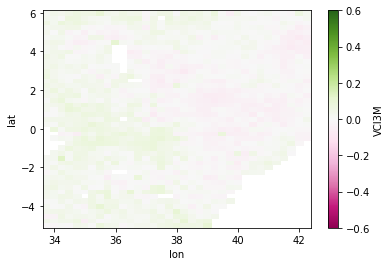

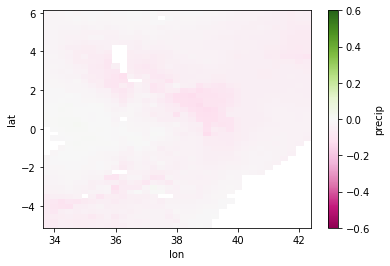

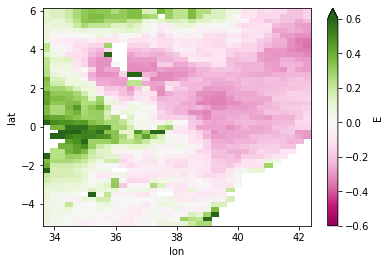

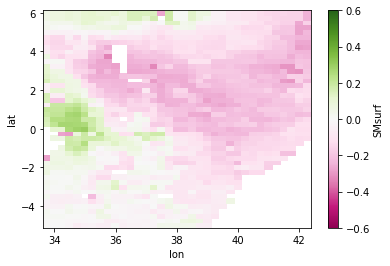

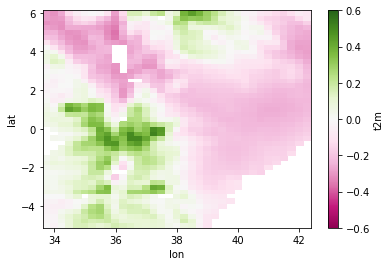

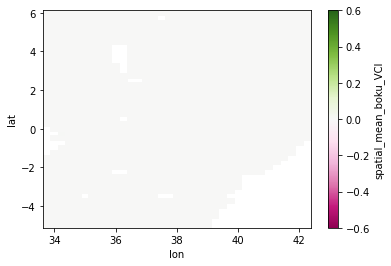

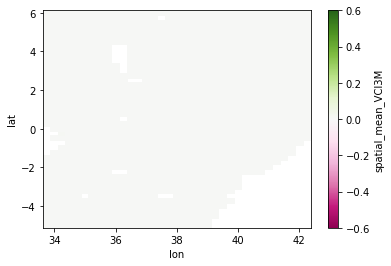

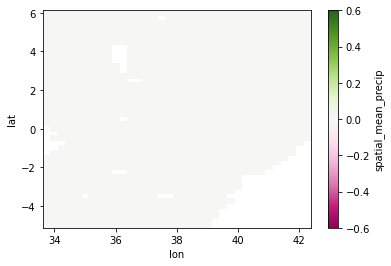

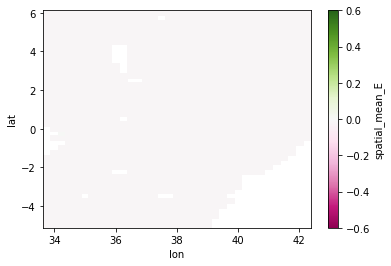

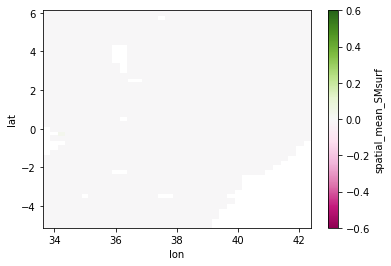

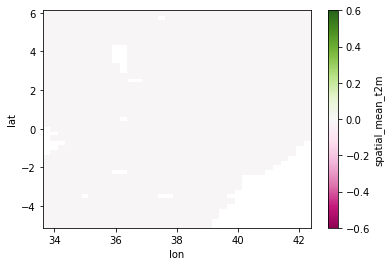

In [37]:
data = all_shap_t3.mean(dim='time')

for var in [v for v in data.data_vars if (v != "boku_VCI")]:
    fig, ax = plt.subplots()
    data[var].plot(ax=ax, vmin=-0.6, vmax=0.6, cmap="PiYG")

# Mean Importance of each feature
- What is the mean magnitude of each variable? 
- (absolute) // 

Compare with the normalised anomaly for the variable in ds

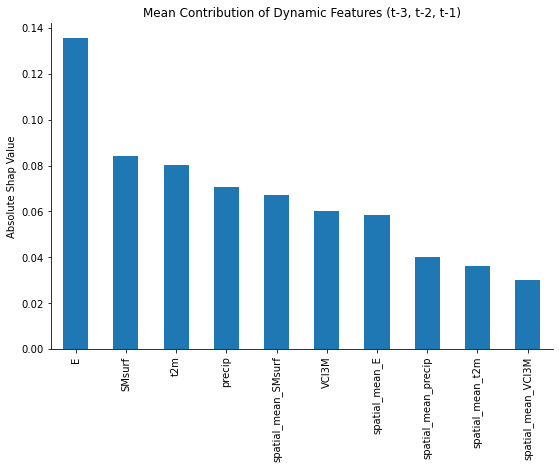

In [38]:
mean_df = np.abs(all_shap).mean().to_array(name='mean_shap').to_dataframe()
mean_df = mean_df.drop([c.name for ix, c in mean_df.iterrows() if 'boku_VCI' in c.name])
mean_df = mean_df.sort_values('mean_shap', ascending=False)

scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# plot the mean absolute contribution
mean_df.plot.bar(legend=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Absolute Shap Value')
ax.set_title('Mean Contribution of Dynamic Features (t-3, t-2, t-1)')

ylim = ax.get_ylim()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

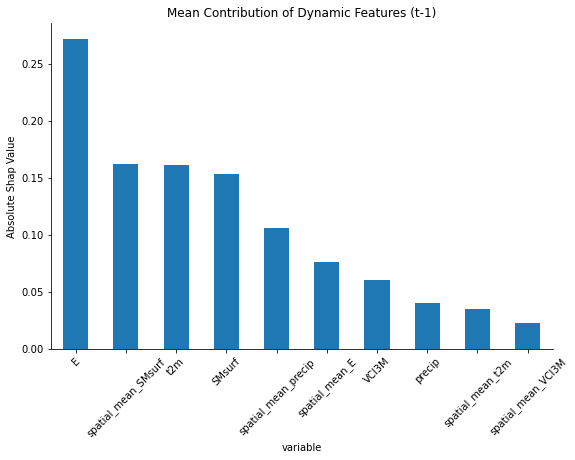

In [44]:
mean_df = np.abs(all_shap_t3).mean().to_array(name='mean_shap').to_dataframe()
mean_df = mean_df.drop([c.name for ix, c in mean_df.iterrows() if 'boku_VCI' in c.name])
mean_df = mean_df.sort_values('mean_shap', ascending=False)
scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# plot the mean absolute contribution
mean_df.plot.bar(legend=False, ax=ax)

ax.set_ylabel('Absolute Shap Value')
ax.set_title('Mean Contribution of Dynamic Features (t-1)')
ax.xaxis.set_tick_params(rotation=45)

ylim = ax.get_ylim()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

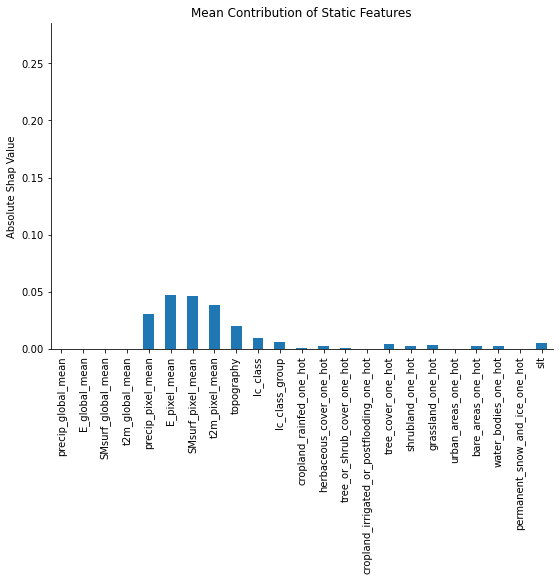

In [40]:
mean_df = np.abs(all_static).mean().to_array(name='mean_shap').to_dataframe()
scale = 1.5
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# plot the mean absolute contribution
mean_df.plot.bar(legend=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Absolute Shap Value')
ax.set_title('Mean Contribution of Static Features')
ax.set_ylim(ylim)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)